In [53]:
# Setup
import pandas as pd
import numpy as np
import requests
import os
import json
import matplotlib.pyplot as plt 
import warnings
%matplotlib inline
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import folium
from scipy.interpolate import griddata
from numpy import linspace
import geojsoncontour
import plotly.graph_objects as go
import cufflinks
from plotly.offline import iplot, plot
import plotly.express as px
import plotly.io as pio


#Make the plots pretty
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='k'#'#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='k'#'#333F4B'
plt.rcParams['ytick.color']='k'#'#333F4B'
plt_txt = 10
plt.rcParams.update({'font.size': plt_txt})
blue = '#0091ea'
green = '#00c853'
orange = '#ffab00'

map_center = (37.993974, -98.927855) #lat lon of the center of the US

GET_URL = "https://api.is-conic.com/api/v0p1/debug/get_data"

# First, we'll load in data from our server and convert it into a pandas dataframe.

In [54]:
header = {"Content-Type": "application/json"}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    response = requests.request("GET", GET_URL, headers=header, verify=False)
if response.status_code != 200:
    raise Exception(response.status_code, response.text)
json_data = response.json()
df = pd.DataFrame.from_dict(json_data)

print(df)

                   key measurement_name        unit      value     timestamp  \
0        otto_stations         otticity  milli_otto       5.00  1.616800e+09   
1    Arjun_weather_kit      temperature     Celsius      21.28  1.617035e+09   
2    Arjun_weather_kit         humidity  Relative %      54.93  1.617035e+09   
3    Arjun_weather_kit         pressure          Pa  101228.00  1.617035e+09   
4    Arjun_weather_kit      temperature     Celsius      22.75  1.617036e+09   
..                 ...              ...         ...        ...           ...   
290        san_diego_4                      Celsius      22.50           NaN   
291        san_diego_5                      Celsius       5.00           NaN   
292        san_diego_6                      Celsius      26.25           NaN   
293        san_diego_7                      Celsius      17.50           NaN   
294        san_diego_8                      Celsius      20.00           NaN   

     receipt_time      lat      lon har

# Next, we'll create a map image to show where all of our sensors are. 
## Click on one of the balloons to see more details

In [55]:
#TODO: account for mobile sensors. groupby id, get the last lat/lon. 
m = folium.Map(location=[map_center[0], map_center[1]], zoom_start=4, tiles="Stamen Terrain")

map_df = df[(~df['timestamp'].isna()) & (df['key'] != 'arjun_test')]
map_df = map_df.groupby('key', as_index=False)
#get the station name, unique units recorded, and last lat/lon
for name, grp in map_df:
    units = list(grp['unit'].unique())
    start = datetime.utcfromtimestamp(grp['timestamp'].min()).strftime("%m-%d")
    label = "Since: {}. Measures {}".format(start, ", ".join(units))
    folium.Marker([grp.iloc[-1]['lat'], grp.iloc[-1]['lon']], \
                  popup=label, tooltip=name).add_to(m)

m

## Now we'll plot the data from each sensor

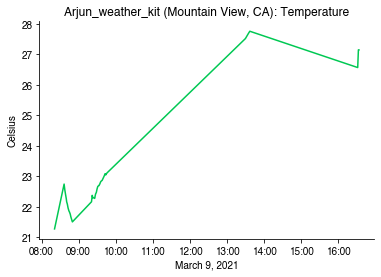

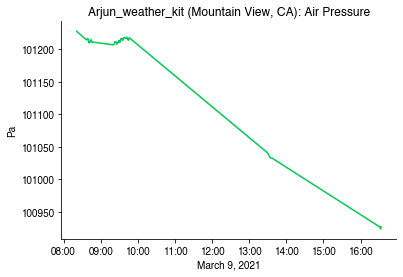

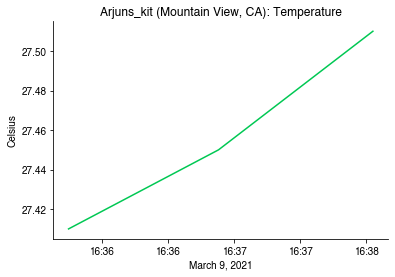

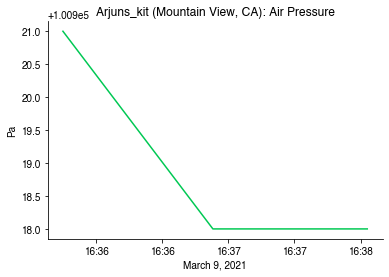

In [56]:
plot_df = df[~df['timestamp'].isna()].sort_values('timestamp', axis=0)
#convert to datetime. subtract 8 hours to get to PST
plot_df['timestamp'] = plot_df['timestamp'].apply(lambda x: \
    datetime.utcfromtimestamp(x-28800))
grouped = plot_df.groupby(['key', 'unit'], as_index=False)
date_form = DateFormatter("%H:%M")

unit_to_mode = {"Celsius":"Temperature", "Pa":"Air Pressure", "RH%":"Humidity", "C": "Temperature"}

for name, grp in grouped:
    if name[1] not in unit_to_mode:
        continue
    fig, ax = plt.subplots()  
    ax.plot('timestamp', 'value', color=green, data=grp)
    ax.set_title("{} (Mountain View, CA): {}".format(name[0], unit_to_mode[name[1]]))
    ax.set_ylabel(name[1])
    ax.set_xlabel("March 9, 2021")
    ax.xaxis.set_major_formatter(date_form)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    plt.show()

# Now, we're going to make a heatmap using some fictitious data 

In [57]:
#this code is from https://towardsdatascience.com/visualizing-spatial-data-with-geojson-heatmaps-1fbe2063ab86

#number of groups to use for the heatmap
# if there are too many groups and some groups are empty then it won't work
n_grades = 4 
type_selected = "Celsius"

#when we get real data we can do filtering by measurement, time unit, etc here

print(df)
heatmap_df = df[df['key'].str.contains("san_diego")]
print(heatmap_df)
heatmap_df = heatmap_df[heatmap_df['unit'] == type_selected]
heatmap_df['receipt_time'] = heatmap_df['receipt_time'].apply(lambda x: \
    datetime.utcfromtimestamp(x-28800))
print(heatmap_df)

"""
#create fake heatmap data
idx = ["value", "lat", "lon", "time"]
s1 = pd.Series([23, 32.632569, -117.102117, 0], index=idx)
s2 = pd.Series([29, 32.7, -117.15, 0], index=idx)
s3 = pd.Series([19, 32.743252, -117.092956, 0], index=idx)
s4 = pd.Series([13, 32.726204, -117.247757, 0], index=idx)
s5 = pd.Series([27, 32.632569, -117.102117, 1], index=idx)
s6 = pd.Series([33, 32.7, -117.15, 1], index=idx)
s7 = pd.Series([23, 32.743252, -117.092956, 1], index=idx)
s8 = pd.Series([14, 32.726204, -117.247757, 1], index=idx)
s9 = pd.Series([31, 32.632569, -117.102117, 2], index=idx)
s10 = pd.Series([37, 32.7, -117.15, 2], index=idx)
s11 = pd.Series([27, 32.743252, -117.092956, 2], index=idx)
s12 = pd.Series([21, 32.726204, -117.247757, 2], index=idx)
heatmap_df = pd.DataFrame([s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12])
"""

                   key measurement_name        unit      value     timestamp  \
0        otto_stations         otticity  milli_otto       5.00  1.616800e+09   
1    Arjun_weather_kit      temperature     Celsius      21.28  1.617035e+09   
2    Arjun_weather_kit         humidity  Relative %      54.93  1.617035e+09   
3    Arjun_weather_kit         pressure          Pa  101228.00  1.617035e+09   
4    Arjun_weather_kit      temperature     Celsius      22.75  1.617036e+09   
..                 ...              ...         ...        ...           ...   
290        san_diego_4                      Celsius      22.50           NaN   
291        san_diego_5                      Celsius       5.00           NaN   
292        san_diego_6                      Celsius      26.25           NaN   
293        san_diego_7                      Celsius      17.50           NaN   
294        san_diego_8                      Celsius      20.00           NaN   

     receipt_time      lat      lon har

'\n#create fake heatmap data\nidx = ["value", "lat", "lon", "time"]\ns1 = pd.Series([23, 32.632569, -117.102117, 0], index=idx)\ns2 = pd.Series([29, 32.7, -117.15, 0], index=idx)\ns3 = pd.Series([19, 32.743252, -117.092956, 0], index=idx)\ns4 = pd.Series([13, 32.726204, -117.247757, 0], index=idx)\ns5 = pd.Series([27, 32.632569, -117.102117, 1], index=idx)\ns6 = pd.Series([33, 32.7, -117.15, 1], index=idx)\ns7 = pd.Series([23, 32.743252, -117.092956, 1], index=idx)\ns8 = pd.Series([14, 32.726204, -117.247757, 1], index=idx)\ns9 = pd.Series([31, 32.632569, -117.102117, 2], index=idx)\ns10 = pd.Series([37, 32.7, -117.15, 2], index=idx)\ns11 = pd.Series([27, 32.743252, -117.092956, 2], index=idx)\ns12 = pd.Series([21, 32.726204, -117.247757, 2], index=idx)\nheatmap_df = pd.DataFrame([s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12])\n'

In [58]:
#in order to map we need 2 items:
# 1. a pandas df where each row is a location id, and a color value to use
# 2. a geojson containing geometries and location ids
# to use a slider we just need multiple of these

#transform into an interpolated array to improve coverage of the map
heatmap_center = heatmap_df['lat'].mean(), heatmap_df['lon'].mean()


def make_contour_and_geojson(df):
    """
    Given a dataframe containing value, lat, and lon, return 
    """
    z = df['value']
    y = df['lat']
    x = df['lon']
    xi = linspace(x.min(),x.max(),100);
    yi = linspace(y.min(),y.max(),100);
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')

    #infer the min_value and step size from n_grades
    min_value = z.min() - 1
    max_value = z.max()
    step_size = (max_value - min_value) / n_grades
    max_value += step_size
    
    #Creating contour plot and turn it into a geojson dict
    cs = plt.contourf(xi,yi,zi,np.arange(min_value, max_value, step_size),cmap=plt.cm.jet)
    geojson = geojsoncontour.contourf_to_geojson(
        contourf=cs,
        ndigits=3,
    )
    heat_geojson=eval(geojson)

    # For each region (aka "feature"), set its ID equal to i.
    # This new array will map those IDs to the lower bound of color bucket the ID belongs to
    arr_temp=np.ones([len(heat_geojson["features"]),2])
    for i in range(len(heat_geojson["features"])):
        heat_geojson["features"][i]["id"] = i
        arr_temp[i,0]=i
        bounds = heat_geojson["features"][i]["properties"]["title"]
        arr_temp[i,1] = bounds.split("-")[0]
    df_contour = pd.DataFrame(arr_temp, columns=["id","title"])

    return df_contour, heat_geojson

'temp-plot.html'

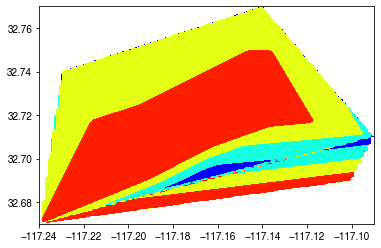

In [59]:
#now create both the data and slider. 
# the data should be a list where each is a choroplethmapbox with the relevant data
# slider mainly contains a list of step dicts mapping args to a boolean list
steps = []
data = []
heatmap_df['hm'] = heatmap_df['receipt_time'].apply(lambda x: x.minute + 60*x.hour)
grouped = heatmap_df.groupby("hm", as_index=False)
i = 0
for name, grp in grouped:
    step = dict(method='restyle', args=['visible', [False] * len(grouped)], label=name)
    step['args'][1][i] = True
    steps.append(step)
    df_contour, heat_geojson = make_contour_and_geojson(grp)
    trace = go.Choroplethmapbox(geojson=heat_geojson,
                            locations=df_contour["id"],
                            z=df_contour["title"],
                            colorscale="jet",  
                            marker_line_width=0,
                            marker={'opacity': 0.5})
    data.append(trace)
    i+=1

sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

layout = go.Layout(
    title="{} Data".format(measurement_selected), title_x=0.4,
    height = 800,
    margin = dict(t = 80, b = 0, l = 0, r = 0),
    font = dict(color = 'dark grey', size = 18),
    mapbox = dict(center = {'lat': heatmap_center[0], 'lon': heatmap_center[1]},
    zoom = 11, style = "carto-positron"), sliders=sliders)

figure={'data': data, 'layout': layout}

plot(figure)

